# Project: Web Scraping and Text Analysis of News Articles

## Import Libraries

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from textblob import TextBlob
import nltk
from nltk.corpus import cmudict
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import zipfile
from docx import Document
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\avino\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\cmudict.zip.


True

## Web Scraping

In [3]:
# Read the "Input.xlsx" file
input_df = pd.read_excel('Input.xlsx')

# Create a directory to store the extracted article text files
if not os.path.exists('Extracted_Articles'):
    os.makedirs('Extracted_Articles')

# Iterate through the DataFrame to extract article text and save as text files
for index, row in input_df.iterrows():
    url = row['URL']
    url_id = row['URL_ID']
    
    # Send a GET request to the URL
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract article title and text
        article_title = soup.find('title').get_text()
        article_text = ' '.join([p.get_text() for p in soup.find_all('p')])
        
        # Save the extracted article text in a text file
        file_path = os.path.join('Extracted_Articles', f'{url_id}.txt')
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(article_title + '\n\n')
            file.write(article_text)
            
        print(f'Article {url_id} extracted and saved.')
    else:
        print(f'Failed to retrieve data for article {url_id}. Status code: {response.status_code}')


Article 37 extracted and saved.
Article 38 extracted and saved.
Article 39 extracted and saved.
Article 40 extracted and saved.
Article 41 extracted and saved.
Article 42 extracted and saved.
Article 43 extracted and saved.
Failed to retrieve data for article 44. Status code: 404
Article 45 extracted and saved.
Article 46 extracted and saved.
Article 47 extracted and saved.
Article 48 extracted and saved.
Article 49 extracted and saved.
Article 50 extracted and saved.
Article 51 extracted and saved.
Article 52 extracted and saved.
Article 53 extracted and saved.
Article 54 extracted and saved.
Article 55 extracted and saved.
Article 56 extracted and saved.
Failed to retrieve data for article 57. Status code: 404
Article 58 extracted and saved.
Article 59 extracted and saved.
Article 60 extracted and saved.
Article 61 extracted and saved.
Article 62 extracted and saved.
Article 63 extracted and saved.
Article 64 extracted and saved.
Article 65 extracted and saved.
Article 66 extracted a

In [4]:
# Extract the stopwords.zip file
with zipfile.ZipFile('StopWords.zip', 'r') as zip_ref:
    zip_ref.extractall('StopWords')

# Load the stopwords from different files
stopwords_files = ['StopWords_Auditor.docx', 'StopWords_DatesandNumbers.docx', 'StopWords_Currencies.docx',
                   'StopWords_Generic.docx', 'StopWords_GenericLong.docx', 'StopWords_Geographic.docx',
                   'StopWords_Names.docx']
stop_words = set()

        
for file in stopwords_files:
    encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']
    found_encoding = None
    for encoding in encodings_to_try:
        try:
            with open(os.path.join('stopwords', file), 'r', encoding=encoding) as f:
                stop_words.update(f.read().splitlines())
            found_encoding = encoding
            break
        except UnicodeDecodeError:
            continue
    if found_encoding is None:
        print(f"Unable to decode {file} with any of the tried encodings.")

In [5]:
# Load the list of positive and negative words from .docx files
positive_doc = Document('positive-words.docx')
positive_words = [paragraph.text for paragraph in positive_doc.paragraphs]

negative_doc = Document('negative-words.docx')
negative_words = [paragraph.text for paragraph in negative_doc.paragraphs]


In [6]:
# Create a list to hold the analysis results as dictionaries
analysis_results_list = []


# Read the list of extracted article files
extracted_files = os.listdir('Extracted_Articles')

# Create an empty DataFrame to store the analysis results
analysis_results = pd.DataFrame(columns=['URL_ID', 'Article_Title', 'Positive_Score', 'Negative_Score', 'Polarity_Score',
                                         'Subjectivity_Score', 'Average_Sentence_Length', 'Complex_Word_Percentage',
                                         'FOG_Index', 'Average_Words_Per_Sentence', 'Complex_Word_Count',
                                         'Word_Count', 'Syllable_Per_Word', 'Personal_Pronoun_Count',
                                         'Average_Word_Length'])

# Iterate through the extracted files and perform text analysis
for file in extracted_files:
    with open(os.path.join('Extracted_Articles', file), 'r', encoding='utf-8') as article_file:
        text = article_file.read()
        
        
        
        # Clean the text by removing numbers and symbols
        cleaned_text = re.sub(r'[0-9]', '', text)  # Remove numbers
        cleaned_text = re.sub(r'[^\w\s]', ' ', cleaned_text)  # Replace symbols with spaces
        
        # Tokenize the text into sentences and words
        sentences = sent_tokenize(cleaned_text)
        words = word_tokenize(cleaned_text)
        
        # Remove punctuation and convert to lowercase
        cleaned_words = [re.sub(r'[^\w\s]', '', word).lower() for word in words if word.isalnum()]
        cleaned_words = [word for word in cleaned_words if word not in stop_words]
        
        # Perform sentiment analysis using TextBlob
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        
        # Calculate positive and negative scores using loaded positive and negative words
        positive_score = sum([1 for word in cleaned_words if word in positive_words])
        negative_score = sum([1 for word in cleaned_words if word in negative_words])
        
        # Calculate variables as per the formulas provided
        avg_sentence_length = len(cleaned_words) / len(sentences)
        complex_word_count = sum([1 for word in cleaned_words if len(word) > 2 and word not in stop_words])
        word_count = len(cleaned_words)
        syllable_count = sum([len(re.findall(r'[aeiouAEIOU]+', word)) for word in cleaned_words])
        personal_pronoun_count = len(re.findall(r'\b(I|we|my|ours|us)\b', text, flags=re.IGNORECASE))
        avg_word_length = sum([len(word) for word in cleaned_words]) / len(cleaned_words)
        
        # Calculate FOG index
        fog_index = 0.4 * (avg_sentence_length + (complex_word_count / word_count))
        
        # Append the analysis results to the DataFrame
        result_dict = {'URL_ID': file.split('.')[0],
                       'Article':blob.title,
                                                    'Positive_Score': positive_score,
                                                    'Negative_Score': negative_score,
                                                    'Polarity_Score': polarity,
                                                    'Subjectivity_Score': subjectivity,
                                                    'Average_Sentence_Length': avg_sentence_length,
                                                    'Complex_Word_Percentage': complex_word_count / word_count,
                                                    'FOG_Index': fog_index,
                                                    'Average_Words_Per_Sentence': word_count / len(sentences),
                                                    'Complex_Word_Count': complex_word_count,
                                                    'Word_Count': word_count,
                                                    'Syllable_Per_Word': syllable_count / word_count,
                                                    'Personal_Pronoun_Count': personal_pronoun_count,
                                                    'Average_Word_Length': avg_word_length}
         
        # Append the result_dict to the analysis_results_list
        analysis_results_list.append(result_dict)

# Create the analysis_results DataFrame from the list of dictionaries
analysis_results = pd.DataFrame(analysis_results_list)

# Save the analysis results to an Excel file
analysis_results.to_excel('AnalysisResults.xlsx', index=False)


In [7]:
# read the excel file and convert it into a dataframe.
data = pd.read_excel("AnalysisResults.xlsx")

#print the dataframe
data.head()

,URL_ID,Article,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Average_Sentence_Length,Complex_Word_Percentage,FOG_Index,Average_Words_Per_Sentence,Complex_Word_Count,Word_Count,Syllable_Per_Word,Personal_Pronoun_Count,Average_Word_Length
0,100,<bound method StringlikeMixin.title of TextBlo...,32,46,0.080236,0.336114,1372,0.809767,549.123907,1372,1111,1372,1.802478,6,5.228134
1,101,<bound method StringlikeMixin.title of TextBlo...,12,7,0.191935,0.406355,388,0.824742,155.529897,388,320,388,1.711340,4,4.930412
2,102,<bound method StringlikeMixin.title of TextBlo...,36,51,0.065371,0.427486,1301,0.791699,520.716679,1301,1030,1301,1.694850,15,4.864719
3,103,<bound method StringlikeMixin.title of TextBlo...,19,29,0.062763,0.401391,808,0.821782,323.528713,808,664,808,1.803218,6,5.128713
4,104,<bound method StringlikeMixin.title of TextBlo...,36,61,0.059102,0.390596,1333,0.810203,533.524081,1333,1080,1333,1.801200,6,5.204801


## Exploratory Data Analysis

In [8]:
#shape of the data
data.shape

(111, 15)

In [9]:
#  basic info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   URL_ID                      111 non-null    int64  
 1   Article                     111 non-null    object 
 2   Positive_Score              111 non-null    int64  
 3   Negative_Score              111 non-null    int64  
 4   Polarity_Score              111 non-null    float64
 5   Subjectivity_Score          111 non-null    float64
 6   Average_Sentence_Length     111 non-null    int64  
 7   Complex_Word_Percentage     111 non-null    float64
 8   FOG_Index                   111 non-null    float64
 9   Average_Words_Per_Sentence  111 non-null    int64  
 10  Complex_Word_Count          111 non-null    int64  
 11  Word_Count                  111 non-null    int64  
 12  Syllable_Per_Word           111 non-null    float64
 13  Personal_Pronoun_Count      111 non

In [10]:
#statistical information
data.describe()

,URL_ID,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Average_Sentence_Length,Complex_Word_Percentage,FOG_Index,Average_Words_Per_Sentence,Complex_Word_Count,Word_Count,Syllable_Per_Word,Personal_Pronoun_Count,Average_Word_Length
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,93.819820,41.090090,33.306306,0.100932,0.430148,1253.603604,0.815543,501.767658,1253.603604,1018.684685,1253.603604,1.752427,9.189189,5.046938
std,32.628542,22.513652,22.379289,0.053305,0.052103,576.853822,0.021644,230.738952,576.853822,466.782819,576.853822,0.084712,8.692226,0.233014
min,37.000000,7.000000,4.000000,-0.010384,0.312387,348.000000,0.766234,139.533333,348.000000,290.000000,348.000000,1.532962,2.000000,4.425255
25%,66.500000,25.500000,15.000000,0.061423,0.396665,838.500000,0.800331,335.728960,838.500000,689.500000,838.500000,1.700693,4.000000,4.881547
50%,94.000000,37.000000,29.000000,0.088383,0.427255,1238.000000,0.815572,495.542811,1238.000000,1029.000000,1238.000000,1.750503,6.000000,5.061244
75%,121.500000,55.000000,46.500000,0.132456,0.458684,1714.500000,0.831804,686.124836,1714.500000,1391.500000,1714.500000,1.798755,11.000000,5.175393
max,150.000000,112.000000,97.000000,0.247697,0.595731,3428.000000,0.861650,1371.540957,3428.000000,2922.000000,3428.000000,1.976000,48.000000,5.613714


In [11]:
#null values
data.isnull().sum()

URL_ID                        0
Article                       0
Positive_Score                0
Negative_Score                0
Polarity_Score                0
Subjectivity_Score            0
Average_Sentence_Length       0
Complex_Word_Percentage       0
FOG_Index                     0
Average_Words_Per_Sentence    0
Complex_Word_Count            0
Word_Count                    0
Syllable_Per_Word             0
Personal_Pronoun_Count        0
Average_Word_Length           0
dtype: int64

In [12]:
#duplicate values
data.duplicated().sum()

0

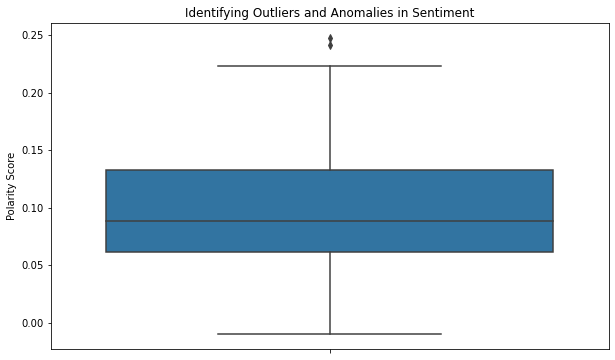

In [14]:
# Create box plots to identify outliers in sentiment scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, y='Polarity_Score')
plt.ylabel('Polarity Score')
plt.title('Identifying Outliers and Anomalies in Sentiment')
plt.show()


In [17]:
new_df = data.drop("Article",axis = 1)
new_df.head()

,URL_ID,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Average_Sentence_Length,Complex_Word_Percentage,FOG_Index,Average_Words_Per_Sentence,Complex_Word_Count,Word_Count,Syllable_Per_Word,Personal_Pronoun_Count,Average_Word_Length
0,100,32,46,0.080236,0.336114,1372,0.809767,549.123907,1372,1111,1372,1.802478,6,5.228134
1,101,12,7,0.191935,0.406355,388,0.824742,155.529897,388,320,388,1.711340,4,4.930412
2,102,36,51,0.065371,0.427486,1301,0.791699,520.716679,1301,1030,1301,1.694850,15,4.864719
3,103,19,29,0.062763,0.401391,808,0.821782,323.528713,808,664,808,1.803218,6,5.128713
4,104,36,61,0.059102,0.390596,1333,0.810203,533.524081,1333,1080,1333,1.801200,6,5.204801


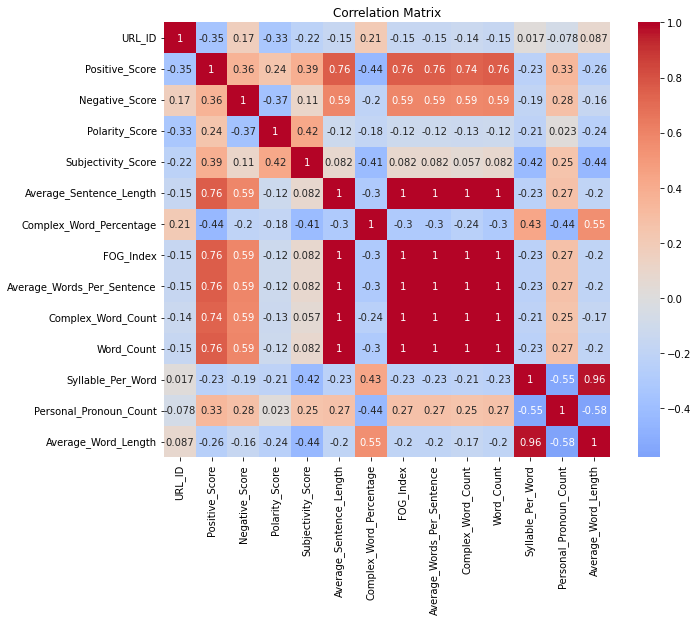

In [18]:
# Correlation matrix

correlation_matrix = new_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

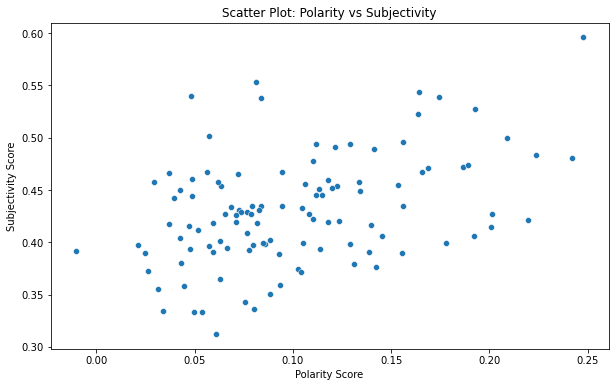

In [19]:
# Scatter plot: Polarity vs Subjectivity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Polarity_Score', y='Subjectivity_Score')
plt.title('Scatter Plot: Polarity vs Subjectivity')
plt.xlabel('Polarity Score')
plt.ylabel('Subjectivity Score')
plt.show()

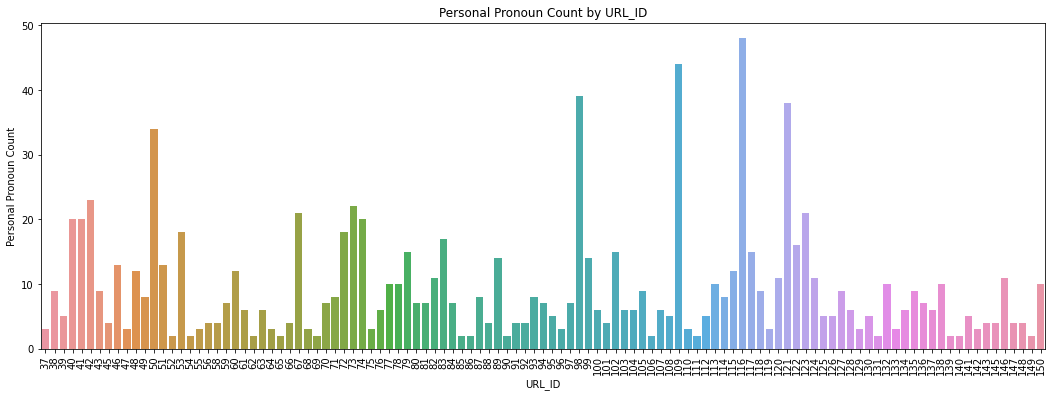

In [20]:
# Bar plot: Personal Pronoun Count by URL_ID
plt.figure(figsize=(18, 6))
sns.barplot(data=data, x='URL_ID', y='Personal_Pronoun_Count')
plt.title('Personal Pronoun Count by URL_ID')
plt.xlabel('URL_ID')
plt.ylabel('Personal Pronoun Count')
plt.xticks(rotation=90)
plt.show()

In [21]:
# Define the threshold for classifying sentiment
threshold = 0.2

# Function to classify sentiment
def classify_sentiment(row):
    if row['Positive_Score'] - row['Negative_Score'] > threshold:
        return 'Positive'
    elif row['Negative_Score'] - row['Positive_Score'] > threshold:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to classify sentiments and create a new column
data['Sentiment_Label'] = data.apply(classify_sentiment, axis=1)

# Count the number of articles for each sentiment label
sentiment_counts = data['Sentiment_Label'].value_counts()

print("Sentiment Label Counts:")
print(sentiment_counts)


Sentiment Label Counts:
Sentiment_Label
Positive    65
Negative    45
Neutral      1
Name: count, dtype: int64


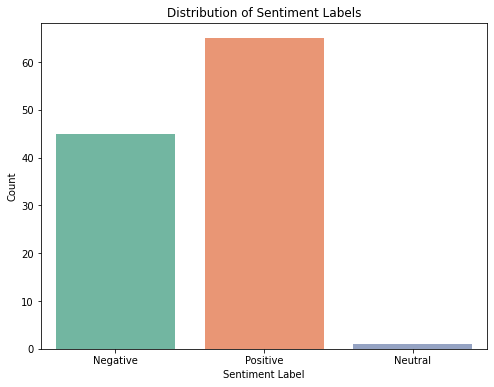

In [22]:
# Create a bar plot to visualize the distribution of sentiment labels
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_Label', data=data, palette='Set2')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [23]:
#Sentiment Analysis by Subjectivity Score Range:

# Create categories for subjectivity score
data['Subjectivity_Category'] = pd.cut(data['Subjectivity_Score'], bins=[0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])

# Calculate average sentiment scores for each category
sentiment_by_subjectivity_range = data.groupby('Subjectivity_Category')[['Positive_Score', 'Negative_Score']].mean()

print("Sentiment by Subjectivity Category:")
print(sentiment_by_subjectivity_range)


Sentiment by Subjectivity Category:
                       Positive_Score  Negative_Score
Subjectivity_Category                                
Low                               NaN             NaN
Medium                       41.09009       33.306306
High                              NaN             NaN


In [24]:
#Sentiment Analysis by Polarity Score Range:
    
    
# Create categories for polarity score
data['Polarity_Category'] = pd.cut(data['Polarity_Score'], bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])

# Calculate average sentiment scores for each category
sentiment_by_polarity = data.groupby('Polarity_Category')[['Positive_Score', 'Negative_Score']].mean()

print("Sentiment by Polarity Category:")
print(sentiment_by_polarity)


Sentiment by Polarity Category:
                   Positive_Score  Negative_Score
Polarity_Category                                
Negative                      NaN             NaN
Neutral                 34.852459       37.885246
Positive                48.700000       27.720000


In [25]:
#Sentiment Analysis by Article Length:

# Create categories for article length
data['Article_Length_Category'] = pd.cut(data['Word_Count'], bins=[0, 500, 1000, float('inf')], labels=['Short', 'Medium', 'Long'])

# Calculate average sentiment scores for each category
sentiment_by_article_length = data.groupby('Article_Length_Category')[['Positive_Score', 'Negative_Score']].mean()

print("Sentiment by Article Length:")
print(sentiment_by_article_length)


Sentiment by Article Length:
                         Positive_Score  Negative_Score
Article_Length_Category                                
Short                         12.083333        9.083333
Medium                        27.714286       16.142857
Long                          51.267606       44.169014


In [26]:
# Preprocess the words in the lists
positive_words = [word.lower() for word in positive_words]
negative_words = [word.lower() for word in negative_words]

# converting the text into lowercase
data['Article'] = data['Article'].str.lower()

# Function to count word occurrences
def count_word_occurrences(text, words_list):
    words = text.split()
    count = sum(1 for word in words if word in words_list)
    return count

# Calculate word counts for positive and negative words
data['Positive_Word_Count'] = data['Article'].apply(lambda text: count_word_occurrences(text, positive_words))
data['Negative_Word_Count'] = data['Article'].apply(lambda text: count_word_occurrences(text, negative_words))

# Separate positive and negative sentiment articles
positive_sentiment = data[data['Positive_Score'] > data['Negative_Score']]
negative_sentiment = data[data['Negative_Score'] > data['Positive_Score']]

# Calculate total positive and negative word counts for each sentiment
total_positive_word_count = positive_sentiment['Positive_Word_Count'].sum()
total_negative_word_count = negative_sentiment['Negative_Word_Count'].sum()

print("Total Positive Word Count:", total_positive_word_count)
print("Total Negative Word Count:", total_negative_word_count)


Total Positive Word Count: 2451
Total Negative Word Count: 1819


In [28]:
data.head()

,URL_ID,Article,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Average_Sentence_Length,Complex_Word_Percentage,FOG_Index,Average_Words_Per_Sentence,...,Word_Count,Syllable_Per_Word,Personal_Pronoun_Count,Average_Word_Length,Sentiment_Label,Subjectivity_Category,Polarity_Category,Article_Length_Category,Positive_Word_Count,Negative_Word_Count
0,100,<bound method stringlikemixin.title of textblo...,32,46,0.080236,0.336114,1372,0.809767,549.123907,1372,...,1372,1.802478,6,5.228134,Negative,Medium,Neutral,Long,28,38
1,101,<bound method stringlikemixin.title of textblo...,12,7,0.191935,0.406355,388,0.824742,155.529897,388,...,388,1.711340,4,4.930412,Positive,Medium,Positive,Short,9,5
2,102,<bound method stringlikemixin.title of textblo...,36,51,0.065371,0.427486,1301,0.791699,520.716679,1301,...,1301,1.694850,15,4.864719,Negative,Medium,Neutral,Long,29,42
3,103,<bound method stringlikemixin.title of textblo...,19,29,0.062763,0.401391,808,0.821782,323.528713,808,...,808,1.803218,6,5.128713,Negative,Medium,Neutral,Medium,16,25
4,104,<bound method stringlikemixin.title of textblo...,36,61,0.059102,0.390596,1333,0.810203,533.524081,1333,...,1333,1.801200,6,5.204801,Negative,Medium,Neutral,Long,33,53


In [29]:
# Grouping by Complex_Word_Percentage and calculating average sentiment scores
sentiment_by_complexity = data.groupby('Complex_Word_Percentage')[['Positive_Score', 'Negative_Score']].mean()

# Grouping by Subjectivity_Score and calculating average sentiment scores
sentiment_by_subjectivity = data.groupby('Subjectivity_Score')[['Positive_Score', 'Negative_Score']].mean()

# Grouping by Average_Word_Length and calculating average sentiment scores
sentiment_by_word_length = data.groupby('Average_Word_Length')[['Positive_Score', 'Negative_Score']].mean()

# Print the results
print("Sentiment by Complex Word Percentage:")
print(sentiment_by_complexity)

print("\nSentiment by Subjectivity Score:")
print(sentiment_by_subjectivity)

print("\nSentiment by Average Word Length:")
print(sentiment_by_word_length)


Sentiment by Complex Word Percentage:
                         Positive_Score  Negative_Score
Complex_Word_Percentage                                
0.766234                            7.0            25.0
0.767781                           59.0            12.0
0.767850                           88.0            49.0
0.773545                           80.0            28.0
0.780079                          112.0            43.0
...                                 ...             ...
0.854286                            8.0             4.0
0.857027                           30.0            37.0
0.858286                           37.0            25.0
0.860465                            8.0             7.0
0.861650                           15.0            44.0

[109 rows x 2 columns]

Sentiment by Subjectivity Score:
                    Positive_Score  Negative_Score
Subjectivity_Score                                
0.312387                      12.0             4.0
0.333101               

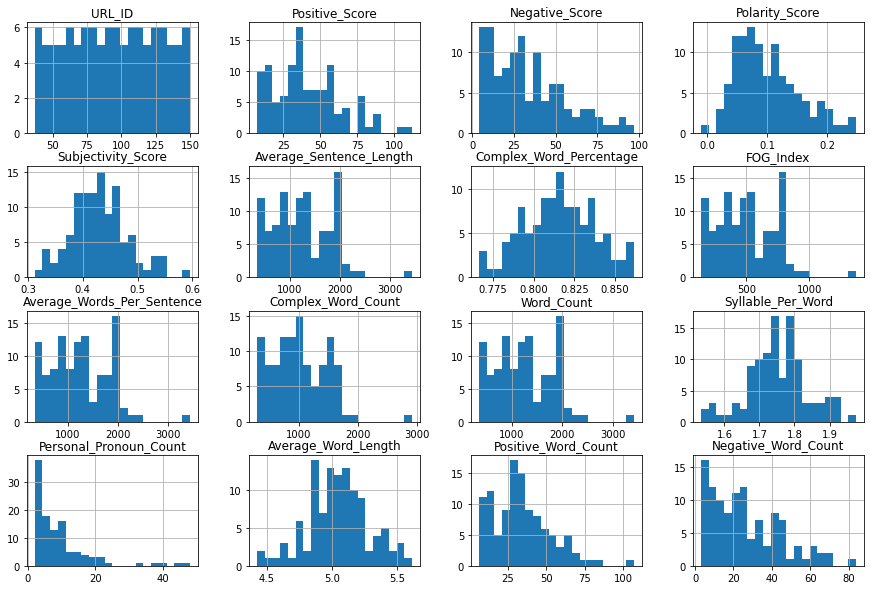

In [30]:
# Histograms
data.hist(bins=20, figsize=(15, 10))
plt.show()

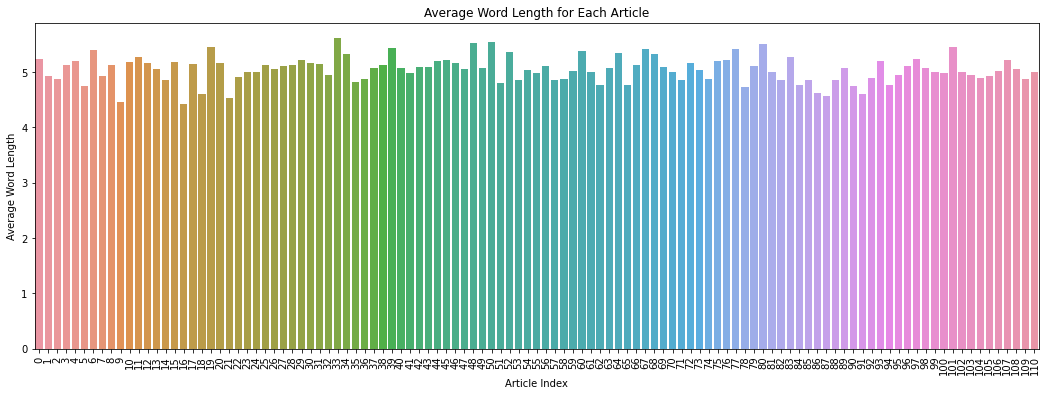

In [82]:
# Bar plot for Average_Word_Length
plt.figure(figsize=(1, 6))
sns.barplot(x=data.index, y=data["Average_Word_Length"])
plt.xlabel("Article Index")
plt.ylabel("Average Word Length")
plt.title("Average Word Length for Each Article")
plt.xticks(rotation=90)
plt.show()

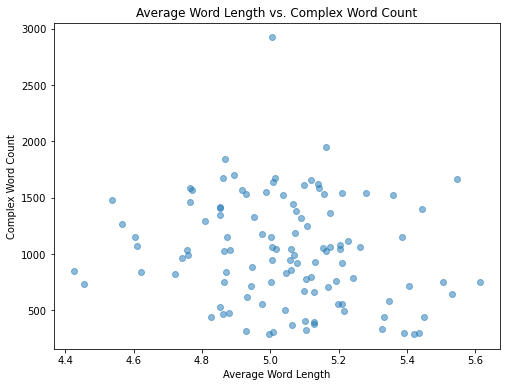

In [32]:
# Scatter plot of Average_Word_Length vs. Complex_Word_Count
plt.figure(figsize=(8, 6))
plt.scatter(data["Average_Word_Length"], data["Complex_Word_Count"], alpha=0.5)
plt.xlabel("Average Word Length")
plt.ylabel("Complex Word Count")
plt.title("Average Word Length vs. Complex Word Count")
plt.show()

In [33]:
# Sentiment Analysis Insights
positive_sentiment = data[data["Positive_Score"] > data["Negative_Score"]]
negative_sentiment = data[data["Negative_Score"] > data["Positive_Score"]]

print("Number of articles with strong positive sentiment:", len(positive_sentiment))
print("Number of articles with strong negative sentiment:", len(negative_sentiment))

Number of articles with strong positive sentiment: 65
Number of articles with strong negative sentiment: 45


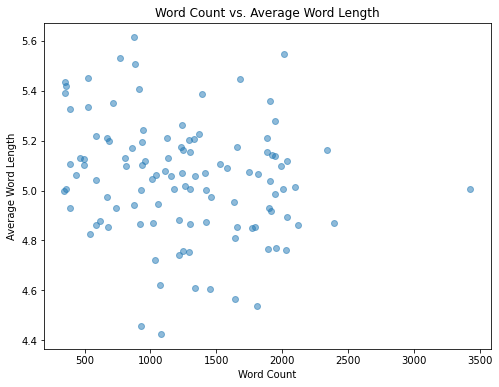

In [34]:
# Scatter plot of Word_Count vs. Average_Word_Length
plt.figure(figsize=(8, 6))
plt.scatter(data["Word_Count"], data["Average_Word_Length"], alpha=0.5)
plt.xlabel("Word Count")
plt.ylabel("Average Word Length")
plt.title("Word Count vs. Average Word Length")
plt.show()


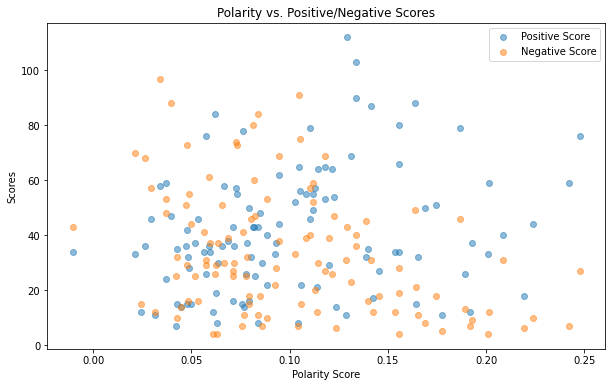

In [35]:
# Scatter plot of Polarity_Score vs. Positive_Score/Negative_Score
plt.figure(figsize=(10, 6))
plt.scatter(data["Polarity_Score"], data["Positive_Score"], label="Positive Score", alpha=0.5)
plt.scatter(data["Polarity_Score"], data["Negative_Score"], label="Negative Score", alpha=0.5)
plt.xlabel("Polarity Score")
plt.ylabel("Scores")
plt.title("Polarity vs. Positive/Negative Scores")
plt.legend()
plt.show()


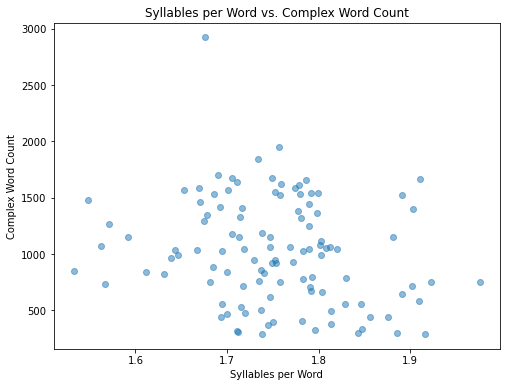

In [36]:
# Scatter plot of Syllable_Per_Word vs. Complex_Word_Count
plt.figure(figsize=(8, 6))
plt.scatter(data["Syllable_Per_Word"], data["Complex_Word_Count"], alpha=0.5)
plt.xlabel("Syllables per Word")
plt.ylabel("Complex Word Count")
plt.title("Syllables per Word vs. Complex Word Count")
plt.show()


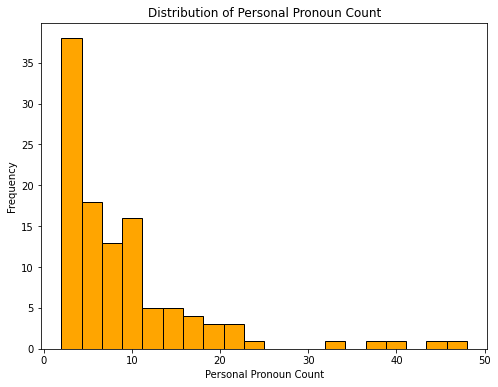

In [37]:
# Histogram of Personal_Pronoun_Count
plt.figure(figsize=(8, 6))
plt.hist(data["Personal_Pronoun_Count"], bins=20, color='orange', edgecolor='black')
plt.xlabel("Personal Pronoun Count")
plt.ylabel("Frequency")
plt.title("Distribution of Personal Pronoun Count")
plt.show()


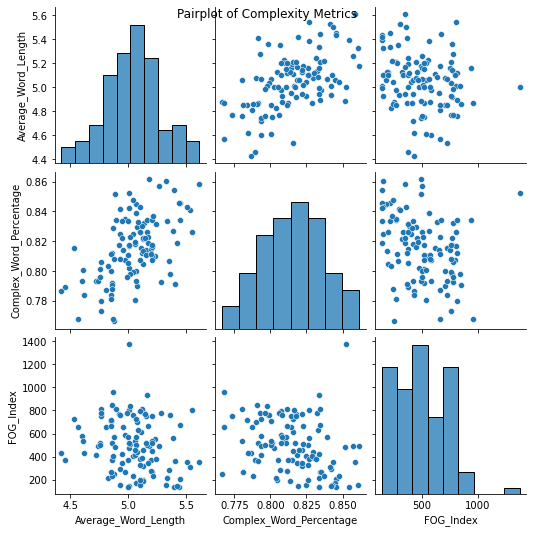

In [38]:
# Pairplot for complexity metrics
complexity_metrics = ["Average_Word_Length", "Complex_Word_Percentage", "FOG_Index"]
sns.pairplot(data[complexity_metrics])
plt.suptitle("Pairplot of Complexity Metrics")
plt.show()


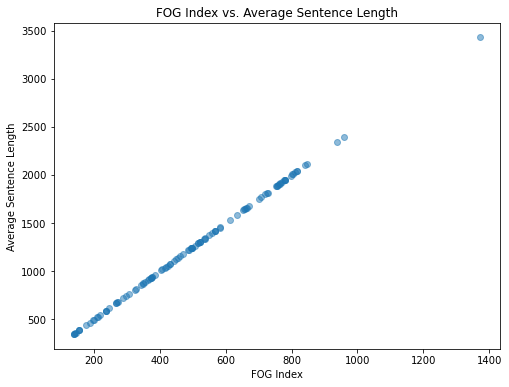

In [40]:
# Scatter plot of FOG_Index vs. Average_Sentence_Length
plt.figure(figsize=(8, 6))
plt.scatter(data["FOG_Index"], data["Average_Sentence_Length"], alpha=0.5)
plt.xlabel("FOG Index")
plt.ylabel("Average Sentence Length")
plt.title("FOG Index vs. Average Sentence Length")
plt.show()


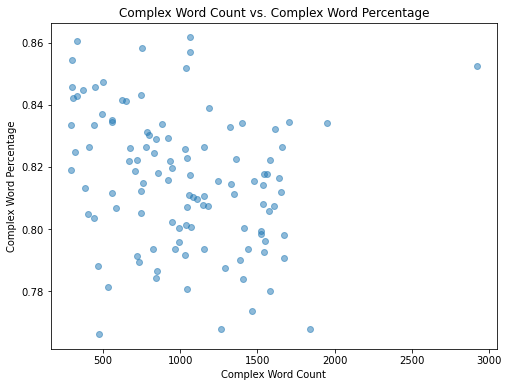

In [41]:
# Scatter plot of Complex_Word_Count vs. Complex_Word_Percentage
plt.figure(figsize=(8, 6))
plt.scatter(data["Complex_Word_Count"], data["Complex_Word_Percentage"], alpha=0.5)
plt.xlabel("Complex Word Count")
plt.ylabel("Complex Word Percentage")
plt.title("Complex Word Count vs. Complex Word Percentage")
plt.show()


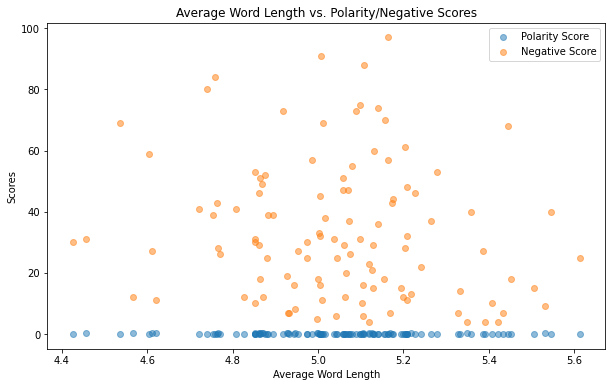

In [42]:
# Scatter plot of Average_Word_Length vs. Polarity_Score/Negative_Score
plt.figure(figsize=(10, 6))
plt.scatter(data["Average_Word_Length"], data["Polarity_Score"], label="Polarity Score", alpha=0.5)
plt.scatter(data["Average_Word_Length"], data["Negative_Score"], label="Negative Score", alpha=0.5)
plt.xlabel("Average Word Length")
plt.ylabel("Scores")
plt.title("Average Word Length vs. Polarity/Negative Scores")
plt.legend()
plt.show()


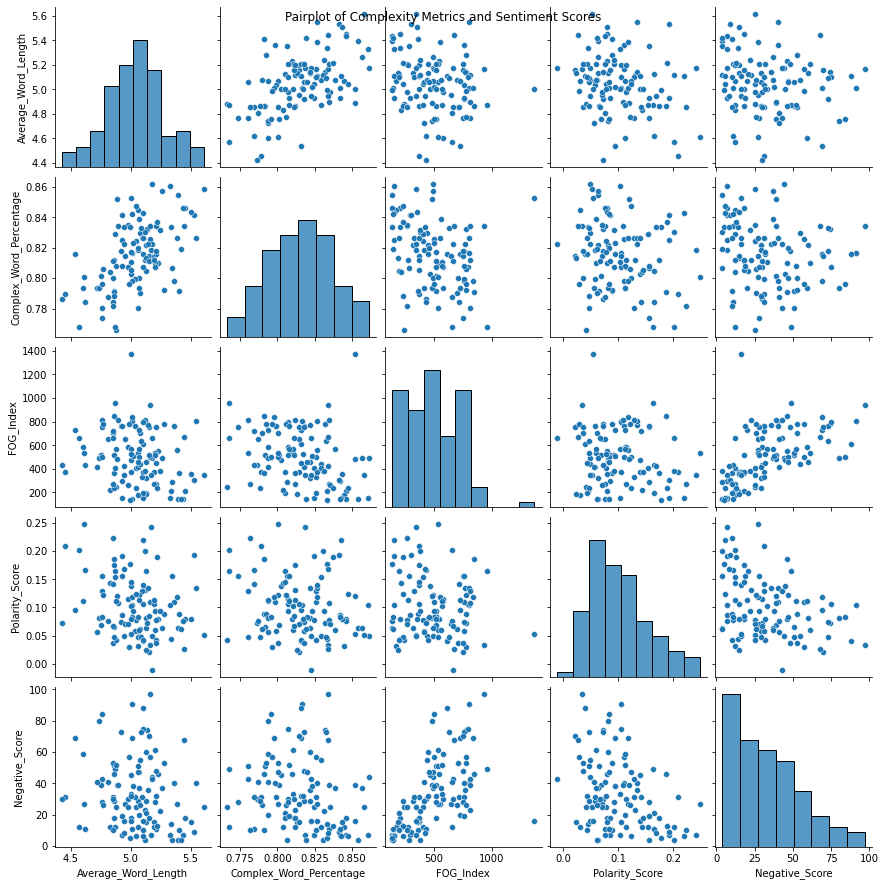

In [43]:
# Pairplot of complexity metrics and sentiment scores
complexity_and_sentiment = ["Average_Word_Length", "Complex_Word_Percentage", "FOG_Index", "Polarity_Score", "Negative_Score"]
sns.pairplot(data[complexity_and_sentiment])
plt.suptitle("Pairplot of Complexity Metrics and Sentiment Scores")
plt.show()


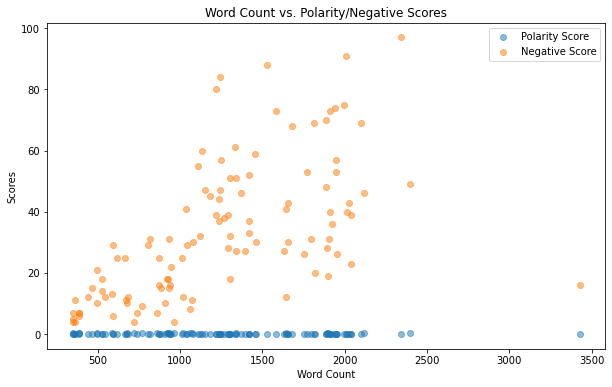

In [45]:
# Scatter plot of Word_Count vs. Polarity_Score/Negative_Score
plt.figure(figsize=(10, 6))
plt.scatter(data["Word_Count"], data["Polarity_Score"], label="Polarity Score", alpha=0.5)
plt.scatter(data["Word_Count"], data["Negative_Score"], label="Negative Score", alpha=0.5)
plt.xlabel("Word Count")
plt.ylabel("Scores")
plt.title("Word Count vs. Polarity/Negative Scores")
plt.legend()
plt.show()


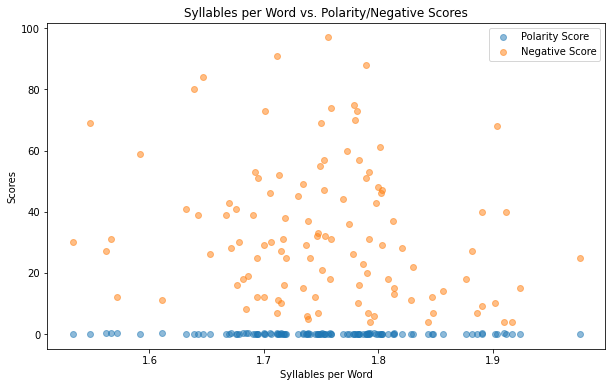

In [46]:
# Scatter plot of Syllable_Per_Word vs. Polarity_Score/Negative_Score
plt.figure(figsize=(10, 6))
plt.scatter(data["Syllable_Per_Word"], data["Polarity_Score"], label="Polarity Score", alpha=0.5)
plt.scatter(data["Syllable_Per_Word"], data["Negative_Score"], label="Negative Score", alpha=0.5)
plt.xlabel("Syllables per Word")
plt.ylabel("Scores")
plt.title("Syllables per Word vs. Polarity/Negative Scores")
plt.legend()
plt.show()


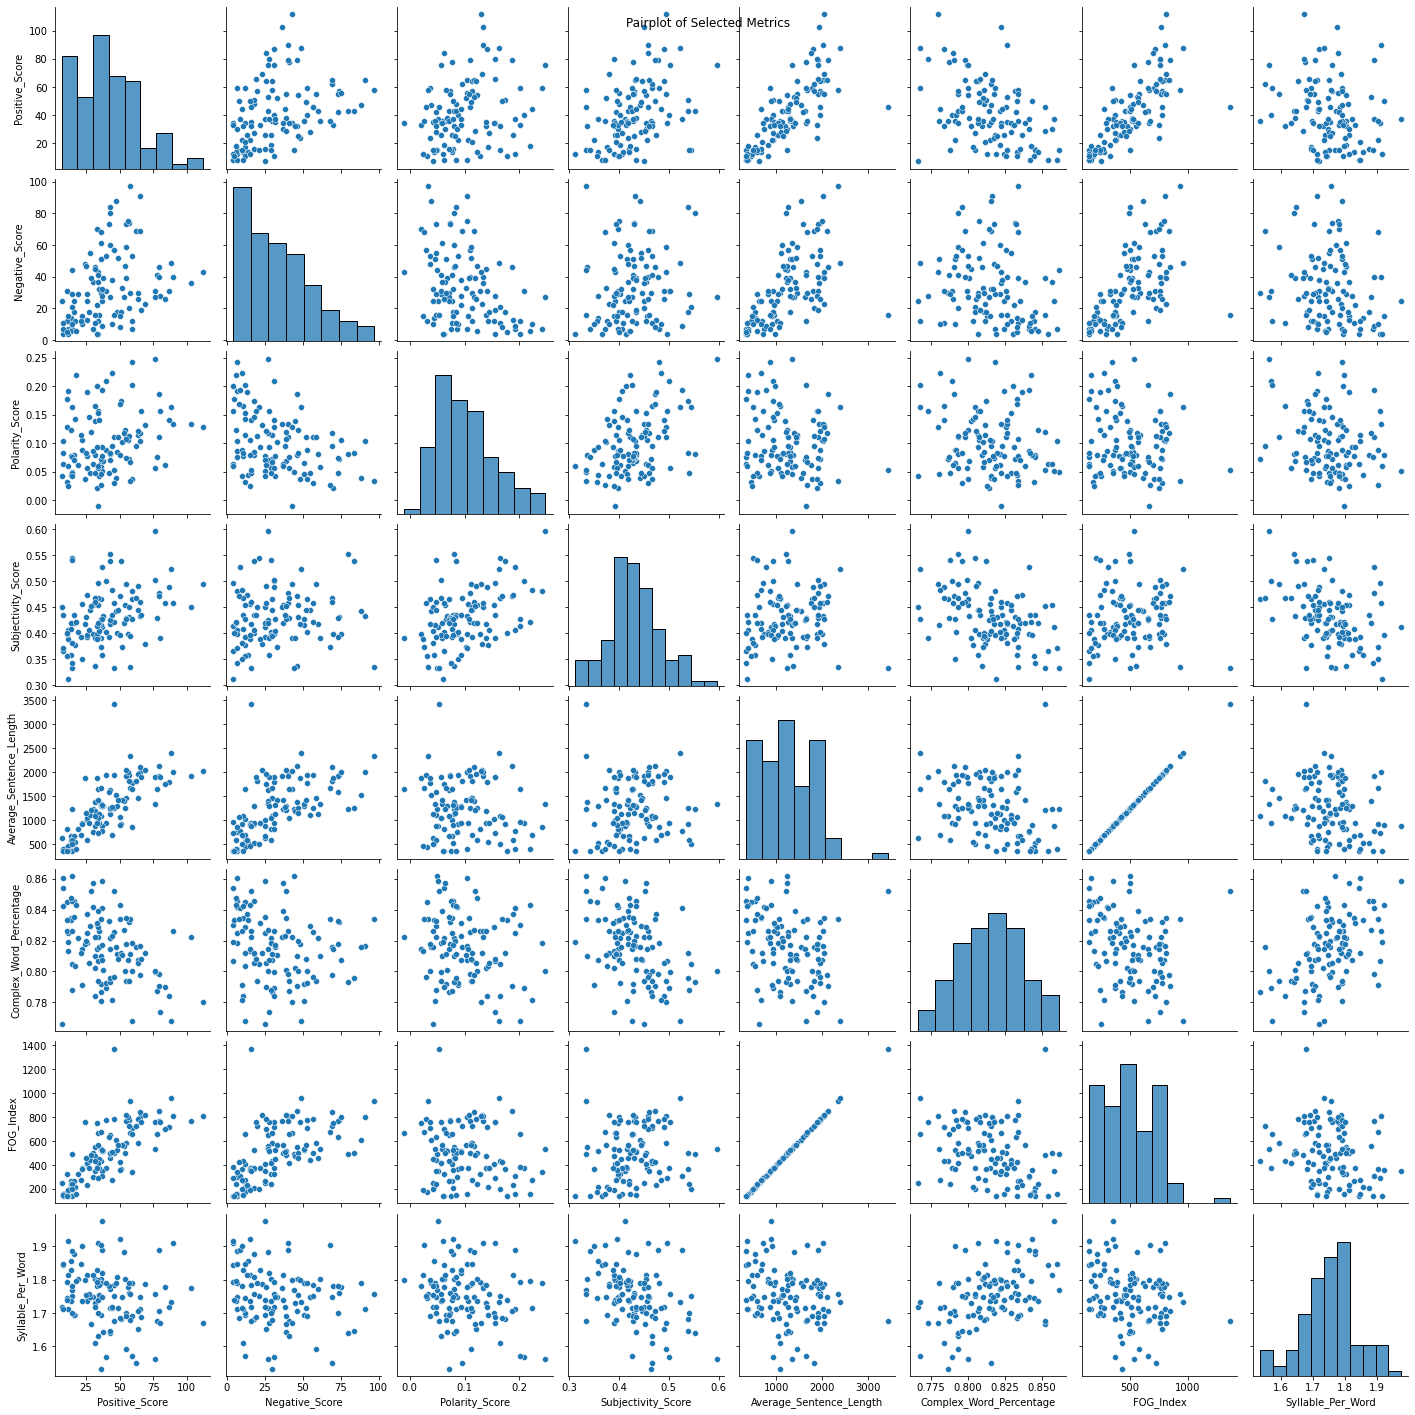

In [47]:
# Pairplot of selected metrics
selected_metrics = ["Positive_Score", "Negative_Score", "Polarity_Score", "Subjectivity_Score",
                    "Average_Sentence_Length", "Complex_Word_Percentage", "FOG_Index", "Syllable_Per_Word"]
sns.pairplot(data[selected_metrics])
plt.suptitle("Pairplot of Selected Metrics")
plt.show()


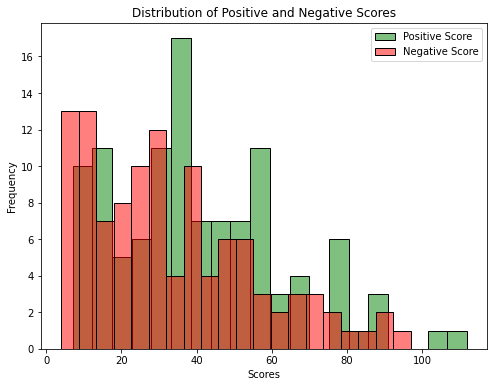

In [48]:
# Distribution of Positive_Score and Negative_Score
plt.figure(figsize=(8, 6))
sns.histplot(data["Positive_Score"], bins=20, color='green', alpha=0.5, label="Positive Score")
sns.histplot(data["Negative_Score"], bins=20, color='red', alpha=0.5, label="Negative Score")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Distribution of Positive and Negative Scores")
plt.legend()
plt.show()


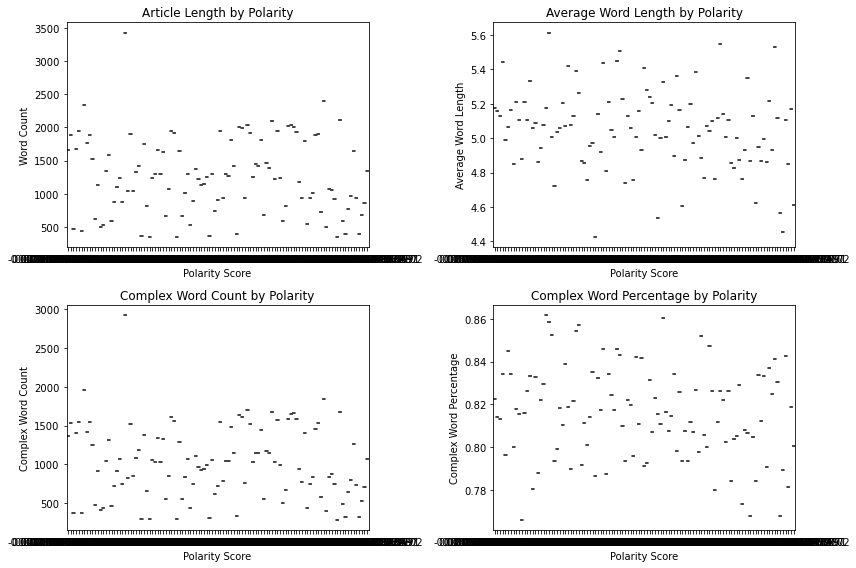

In [49]:
# Box plots of Word_Count and complexity metrics by Polarity
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x=data["Polarity_Score"], y=data["Word_Count"])
plt.xlabel("Polarity Score")
plt.ylabel("Word Count")
plt.title("Article Length by Polarity")

plt.subplot(2, 2, 2)
sns.boxplot(x=data["Polarity_Score"], y=data["Average_Word_Length"])
plt.xlabel("Polarity Score")
plt.ylabel("Average Word Length")
plt.title("Average Word Length by Polarity")

plt.subplot(2, 2, 3)
sns.boxplot(x=data["Polarity_Score"], y=data["Complex_Word_Count"])
plt.xlabel("Polarity Score")
plt.ylabel("Complex Word Count")
plt.title("Complex Word Count by Polarity")

plt.subplot(2, 2, 4)
sns.boxplot(x=data["Polarity_Score"], y=data["Complex_Word_Percentage"])
plt.xlabel("Polarity Score")
plt.ylabel("Complex Word Percentage")
plt.title("Complex Word Percentage by Polarity")

plt.tight_layout()
plt.show()


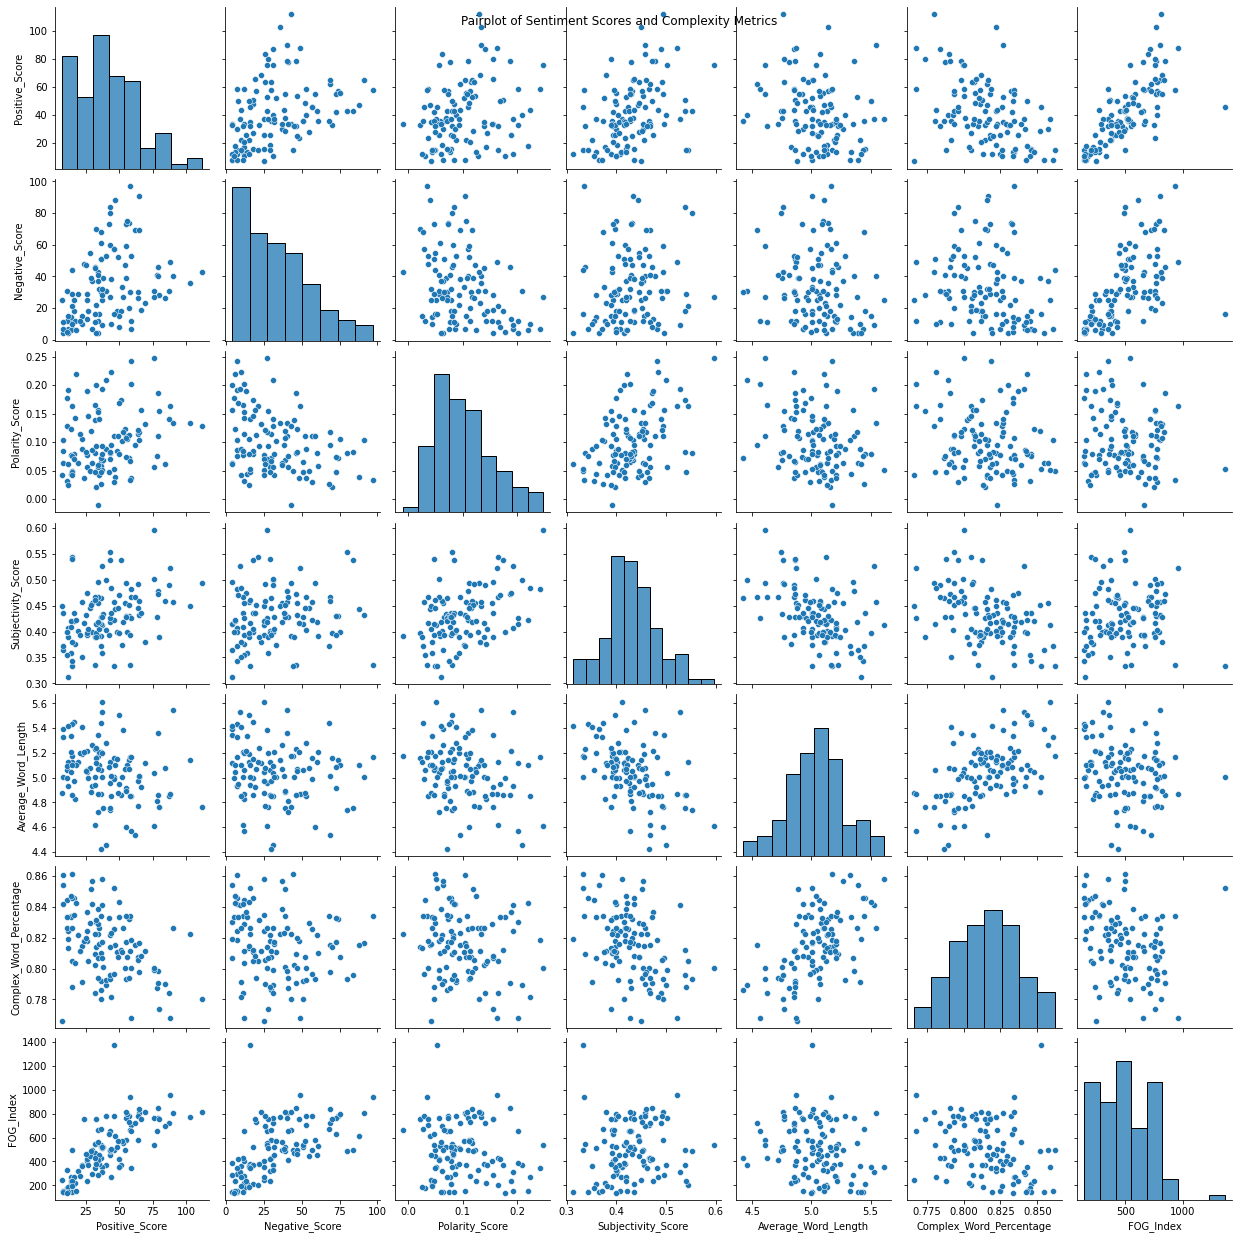

In [52]:
# Pairplot of sentiment scores and complexity metrics
sentiment_and_complexity = ["Positive_Score", "Negative_Score", "Polarity_Score", "Subjectivity_Score",
                            "Average_Word_Length", "Complex_Word_Percentage", "FOG_Index"]
sns.pairplot(data[sentiment_and_complexity])
plt.suptitle("Pairplot of Sentiment Scores and Complexity Metrics")
plt.show()


### Questions

#### Question 1: What is the average positive and negative sentiment across all articles?

In [53]:
# Calculate average positive and negative sentiment
average_positive_score = data["Positive_Score"].mean()
average_negative_score = data["Negative_Score"].mean()

print(f"Average Positive Score: {average_positive_score:.2f}")
print(f"Average Negative Score: {average_negative_score:.2f}")


Average Positive Score: 41.09
Average Negative Score: 33.31


#### Question 2: How many articles have a higher positive score than negative score?

In [54]:
# Count articles with higher positive score than negative score
higher_positive_articles = data[data["Positive_Score"] > data["Negative_Score"]]
num_higher_positive = len(higher_positive_articles)

print(f"Number of articles with higher positive score: {num_higher_positive}")


Number of articles with higher positive score: 65


#### Question 3: What is the most common average word length range among the articles?

In [56]:
# Define ranges for average word length
bins = [0, 4, 6, 8, float("inf")]
labels = ["<4", "4-6", "6-8", ">=8"]

# Categorize average word length
data["Word_Length_Range"] = pd.cut(data["Average_Word_Length"], bins=bins, labels=labels)

# Count articles in each range
word_length_counts = data["Word_Length_Range"].value_counts()

print("Word Length Range Distribution:")
print(word_length_counts)


Word Length Range Distribution:
Word_Length_Range
4-6    111
<4       0
6-8      0
>=8      0
Name: count, dtype: int64


#### Question 4: Is there a correlation between average sentence length and complexity (FOG Index)?

In [57]:
# Calculate correlation between Average_Sentence_Length and FOG_Index
correlation = data["Average_Sentence_Length"].corr(data["FOG_Index"])

print(f"Correlation between Average Sentence Length and FOG Index: {correlation:.2f}")


Correlation between Average Sentence Length and FOG Index: 1.00


#### Question 5: Which articles have the highest and lowest Polarity Scores?

In [59]:
# Find articles with highest and lowest Polarity Scores
max_polarity_article = data[data["Polarity_Score"] == data["Polarity_Score"].max()]
min_polarity_article = data[data["Polarity_Score"] == data["Polarity_Score"].min()]

print("Article with highest Polarity Score:")
max_polarity_article

Article with highest Polarity Score:


,URL_ID,Article,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Average_Sentence_Length,Complex_Word_Percentage,FOG_Index,Average_Words_Per_Sentence,...,Syllable_Per_Word,Personal_Pronoun_Count,Average_Word_Length,Sentiment_Label,Subjectivity_Category,Polarity_Category,Article_Length_Category,Positive_Word_Count,Negative_Word_Count,Word_Length_Range
91,80,<bound method stringlikemixin.title of textblo...,76,27,0.247697,0.595731,1339,0.800597,535.920239,1339,...,1.56236,7,4.610904,Positive,Medium,Positive,Long,53,17,4-6


In [60]:
print("\nArticle with lowest Polarity Score:")
min_polarity_article


Article with lowest Polarity Score:


,URL_ID,Article,Positive_Score,Negative_Score,Polarity_Score,Subjectivity_Score,Average_Sentence_Length,Complex_Word_Percentage,FOG_Index,Average_Words_Per_Sentence,...,Syllable_Per_Word,Personal_Pronoun_Count,Average_Word_Length,Sentiment_Label,Subjectivity_Category,Polarity_Category,Article_Length_Category,Positive_Word_Count,Negative_Word_Count,Word_Length_Range
15,115,<bound method stringlikemixin.title of textblo...,34,43,-0.010384,0.391637,1657,0.822571,663.129028,1657,...,1.797827,12,5.174412,Negative,Medium,Neutral,Long,29,41,4-6


#### Question 6: How does the distribution of personal pronoun count differ for positive and negative sentiment articles?

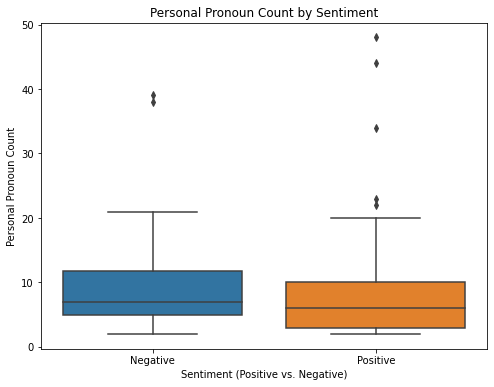

In [61]:
# Box plot of Personal_Pronoun_Count by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x=data["Positive_Score"] > data["Negative_Score"], y=data["Personal_Pronoun_Count"])
plt.xlabel("Sentiment (Positive vs. Negative)")
plt.ylabel("Personal Pronoun Count")
plt.title("Personal Pronoun Count by Sentiment")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


#### Question 7: Are articles with higher complexity more subjective?

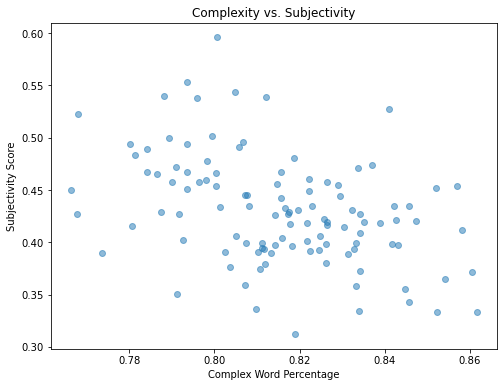

In [62]:
# Scatter plot of Complex_Word_Percentage vs. Subjectivity_Score
plt.figure(figsize=(8, 6))
plt.scatter(data["Complex_Word_Percentage"], data["Subjectivity_Score"], alpha=0.5)
plt.xlabel("Complex Word Percentage")
plt.ylabel("Subjectivity Score")
plt.title("Complexity vs. Subjectivity")
plt.show()


#### Question 8: How does the distribution of positive and negative scores vary based on the subjectivity of articles?

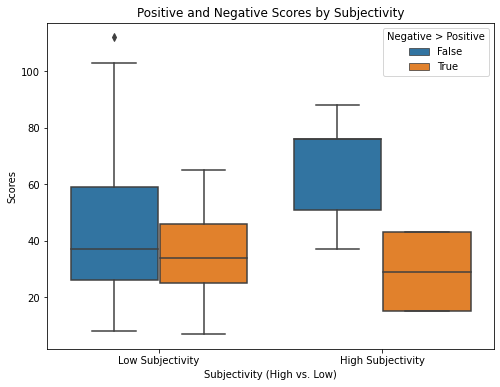

In [63]:
# Box plot of Positive and Negative Scores by Subjectivity
plt.figure(figsize=(8, 6))
sns.boxplot(x=data["Subjectivity_Score"] > 0.5, y=data["Positive_Score"], hue=data["Negative_Score"] > data["Positive_Score"])
plt.xlabel("Subjectivity (High vs. Low)")
plt.ylabel("Scores")
plt.title("Positive and Negative Scores by Subjectivity")
plt.xticks([0, 1], ["Low Subjectivity", "High Subjectivity"])
plt.legend(title="Negative > Positive")
plt.show()


#### Question 9: Is there any relationship between complexity and sentiment scores?

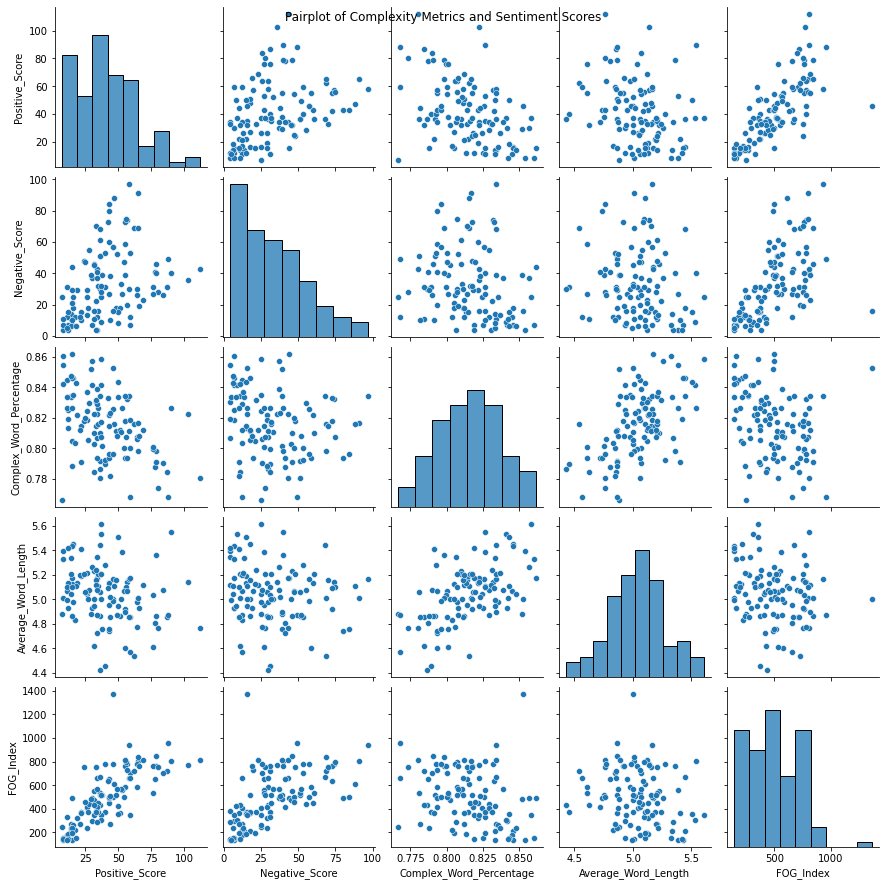

In [64]:
# Pairplot of complexity metrics and sentiment scores
complexity_and_sentiment = ["Positive_Score", "Negative_Score", "Complex_Word_Percentage", "Average_Word_Length", "FOG_Index"]
sns.pairplot(data[complexity_and_sentiment])
plt.suptitle("Pairplot of Complexity Metrics and Sentiment Scores")
plt.show()


#### Question 10: How does the distribution of syllables per word differ for articles with different sentiment?

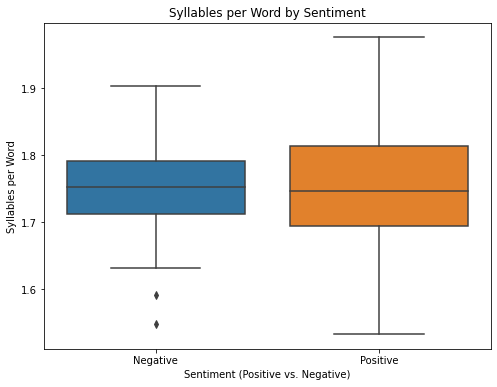

In [65]:
# Box plot of Syllable_Per_Word by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x=data["Positive_Score"] > data["Negative_Score"], y=data["Syllable_Per_Word"])
plt.xlabel("Sentiment (Positive vs. Negative)")
plt.ylabel("Syllables per Word")
plt.title("Syllables per Word by Sentiment")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


#### Question 11: Are longer articles generally more complex?

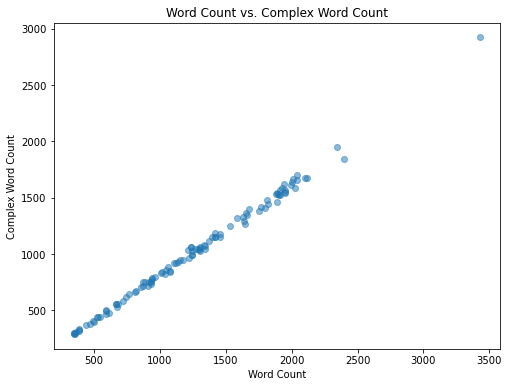

In [66]:
# Scatter plot of Word_Count vs. Complex_Word_Count
plt.figure(figsize=(8, 6))
plt.scatter(data["Word_Count"], data["Complex_Word_Count"], alpha=0.5)
plt.xlabel("Word Count")
plt.ylabel("Complex Word Count")
plt.title("Word Count vs. Complex Word Count")
plt.show()


#### Question 12: How does the average sentence length correlate with the complexity of articles?

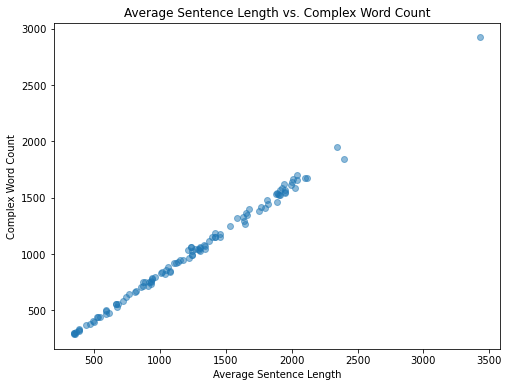

In [67]:
# Scatter plot of Average_Sentence_Length vs. Complex_Word_Count
plt.figure(figsize=(8, 6))
plt.scatter(data["Average_Sentence_Length"], data["Complex_Word_Count"], alpha=0.5)
plt.xlabel("Average Sentence Length")
plt.ylabel("Complex Word Count")
plt.title("Average Sentence Length vs. Complex Word Count")
plt.show()


#### Question 14: How does the use of personal pronouns relate to article sentiment?

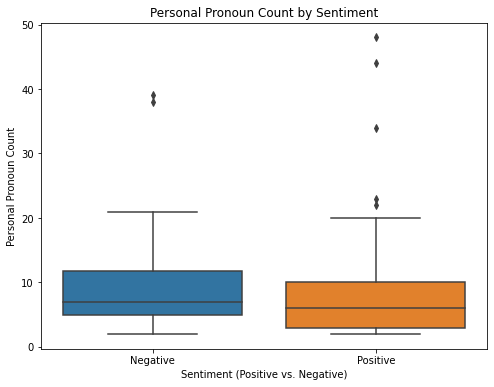

In [69]:
# Box plot of Personal_Pronoun_Count by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x=data["Positive_Score"] > data["Negative_Score"], y=data["Personal_Pronoun_Count"])
plt.xlabel("Sentiment (Positive vs. Negative)")
plt.ylabel("Personal Pronoun Count")
plt.title("Personal Pronoun Count by Sentiment")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


#### Question 15: What is the distribution of average word length for articles with different subjectivity?

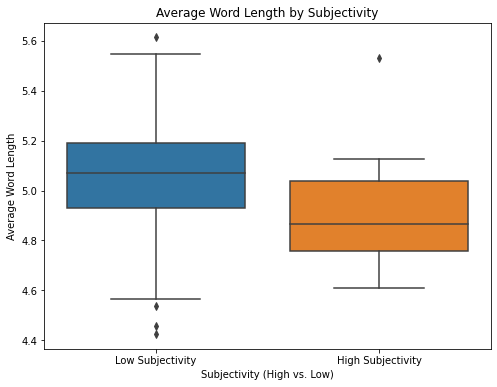

In [70]:
# Box plot of Average_Word_Length by Subjectivity
plt.figure(figsize=(8, 6))
sns.boxplot(x=data["Subjectivity_Score"] > 0.5, y=data["Average_Word_Length"])
plt.xlabel("Subjectivity (High vs. Low)")
plt.ylabel("Average Word Length")
plt.title("Average Word Length by Subjectivity")
plt.xticks([0, 1], ["Low Subjectivity", "High Subjectivity"])
plt.show()


#### Question 16: Are articles with longer sentences more subjective?

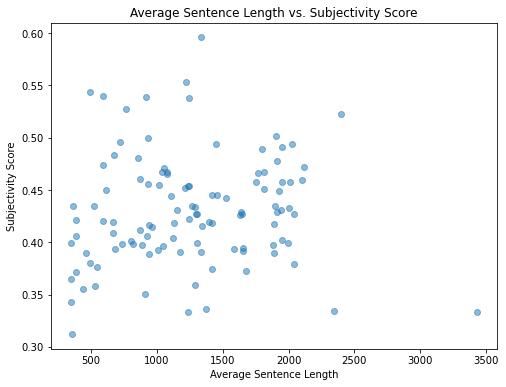

In [71]:
# Scatter plot of Average_Sentence_Length vs. Subjectivity_Score
plt.figure(figsize=(8, 6))
plt.scatter(data["Average_Sentence_Length"], data["Subjectivity_Score"], alpha=0.5)
plt.xlabel("Average Sentence Length")
plt.ylabel("Subjectivity Score")
plt.title("Average Sentence Length vs. Subjectivity Score")
plt.show()


#### Question 12: How does the average sentence length correlate with the complexity of articles?

In [72]:
# Calculate correlation between Average_Sentence_Length and Complex_Word_Count
correlation = data["Average_Sentence_Length"].corr(data["Complex_Word_Count"])

print(f"Correlation between Average Sentence Length and Complex Word Count: {correlation:.2f}")


Correlation between Average Sentence Length and Complex Word Count: 1.00


#### Question 13: What is the average complexity (Complex_Word_Count) for articles with high and low subjectivity?

In [73]:
# Calculate average complexity for high and low subjectivity articles
avg_complexity_high_subjectivity = data[data["Subjectivity_Score"] > 0.5]["Complex_Word_Count"].mean()
avg_complexity_low_subjectivity = data[data["Subjectivity_Score"] <= 0.5]["Complex_Word_Count"].mean()

print(f"Average Complexity for High Subjectivity Articles: {avg_complexity_high_subjectivity:.2f}")
print(f"Average Complexity for Low Subjectivity Articles: {avg_complexity_low_subjectivity:.2f}")


Average Complexity for High Subjectivity Articles: 961.22
Average Complexity for Low Subjectivity Articles: 1023.75


#### Question 14: What is the correlation between positive and negative sentiment scores?

In [74]:
# Calculate correlation between Positive_Score and Negative_Score
correlation = data["Positive_Score"].corr(data["Negative_Score"])

print(f"Correlation between Positive Score and Negative Score: {correlation:.2f}")


Correlation between Positive Score and Negative Score: 0.36


#### Question 15: Do articles with higher subjectivity tend to have higher polarity scores?

In [75]:
# Calculate average polarity for high and low subjectivity articles
avg_polarity_high_subjectivity = data[data["Subjectivity_Score"] > 0.5]["Polarity_Score"].mean()
avg_polarity_low_subjectivity = data[data["Subjectivity_Score"] <= 0.5]["Polarity_Score"].mean()

print(f"Average Polarity for High Subjectivity Articles: {avg_polarity_high_subjectivity:.2f}")
print(f"Average Polarity for Low Subjectivity Articles: {avg_polarity_low_subjectivity:.2f}")


Average Polarity for High Subjectivity Articles: 0.13
Average Polarity for Low Subjectivity Articles: 0.10


#### Question 16: Is there a relationship between the number of syllables per word and complexity?

In [76]:
# Calculate correlation between Syllable_Per_Word and Complex_Word_Count
correlation = data["Syllable_Per_Word"].corr(data["Complex_Word_Count"])

print(f"Correlation between Syllables per Word and Complex Word Count: {correlation:.2f}")


Correlation between Syllables per Word and Complex Word Count: -0.21


#### Question 17: Are articles with longer sentences more complex?

In [77]:
# Calculate correlation between Average_Sentence_Length and Complex_Word_Count
correlation = data["Average_Sentence_Length"].corr(data["Complex_Word_Count"])

print(f"Correlation between Average Sentence Length and Complex Word Count: {correlation:.2f}")


Correlation between Average Sentence Length and Complex Word Count: 1.00


#### Question 18: How does the distribution of subjectivity scores differ between articles with positive and negative sentiment?

In [78]:
# Calculate average subjectivity for positive and negative sentiment articles
avg_subjectivity_positive = data[data["Positive_Score"] > data["Negative_Score"]]["Subjectivity_Score"].mean()
avg_subjectivity_negative = data[data["Negative_Score"] > data["Positive_Score"]]["Subjectivity_Score"].mean()

print(f"Average Subjectivity for Positive Sentiment Articles: {avg_subjectivity_positive:.2f}")
print(f"Average Subjectivity for Negative Sentiment Articles: {avg_subjectivity_negative:.2f}")


Average Subjectivity for Positive Sentiment Articles: 0.43
Average Subjectivity for Negative Sentiment Articles: 0.43


#### Question 19: How many articles have a higher average word length and a high positive score?

In [79]:
# Count articles with high average word length and high positive score
high_word_length_high_positive = data[(data["Average_Word_Length"] > 5) & (data["Positive_Score"] > data["Negative_Score"])]

num_articles = len(high_word_length_high_positive)
print(f"Number of articles with high average word length and high positive score: {num_articles}")


Number of articles with high average word length and high positive score: 38


#### Question 20: Is there a relationship between the number of complex words and the subjectivity of articles?

In [80]:
# Calculate correlation between Complex_Word_Count and Subjectivity_Score
correlation = data["Complex_Word_Count"].corr(data["Subjectivity_Score"])

print(f"Correlation between Complex Word Count and Subjectivity Score: {correlation:.2f}")


Correlation between Complex Word Count and Subjectivity Score: 0.06


In [ ]:
by Vinodhini Rajamanickam